# Predictive Maintenance for Industrial IoT
## Step 4: Predictive Modeling

This notebook covers:
1. Loading preprocessed data from previous steps
2. Implementing time series forecasting with ARIMA
3. Implementing deep learning with LSTM
4. Implementing classification with Random Forest and XGBoost
5. Evaluating model performance


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings

# Configure visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(font_scale=1.2)
warnings.filterwarnings('ignore')

# Display all columns in pandas dataframes
pd.set_option('display.max_columns', None)


## Step 4.1: Load and Prepare Data


Loading training data from ../aps_failure_at_scania_trucks\aps_failure_training_set.csv
Loading test data from ../aps_failure_at_scania_trucks\aps_failure_test_set.csv
Loaded training data: (60000, 170) features, (60000,) labels
Loaded test data: (16000, 170) features, (16000,) labels

Preprocessing data...
Preprocessing complete.
Selected 20 top features for modeling.
X_train_top shape: (60000, 20)
X_test_top shape: (16000, 20)


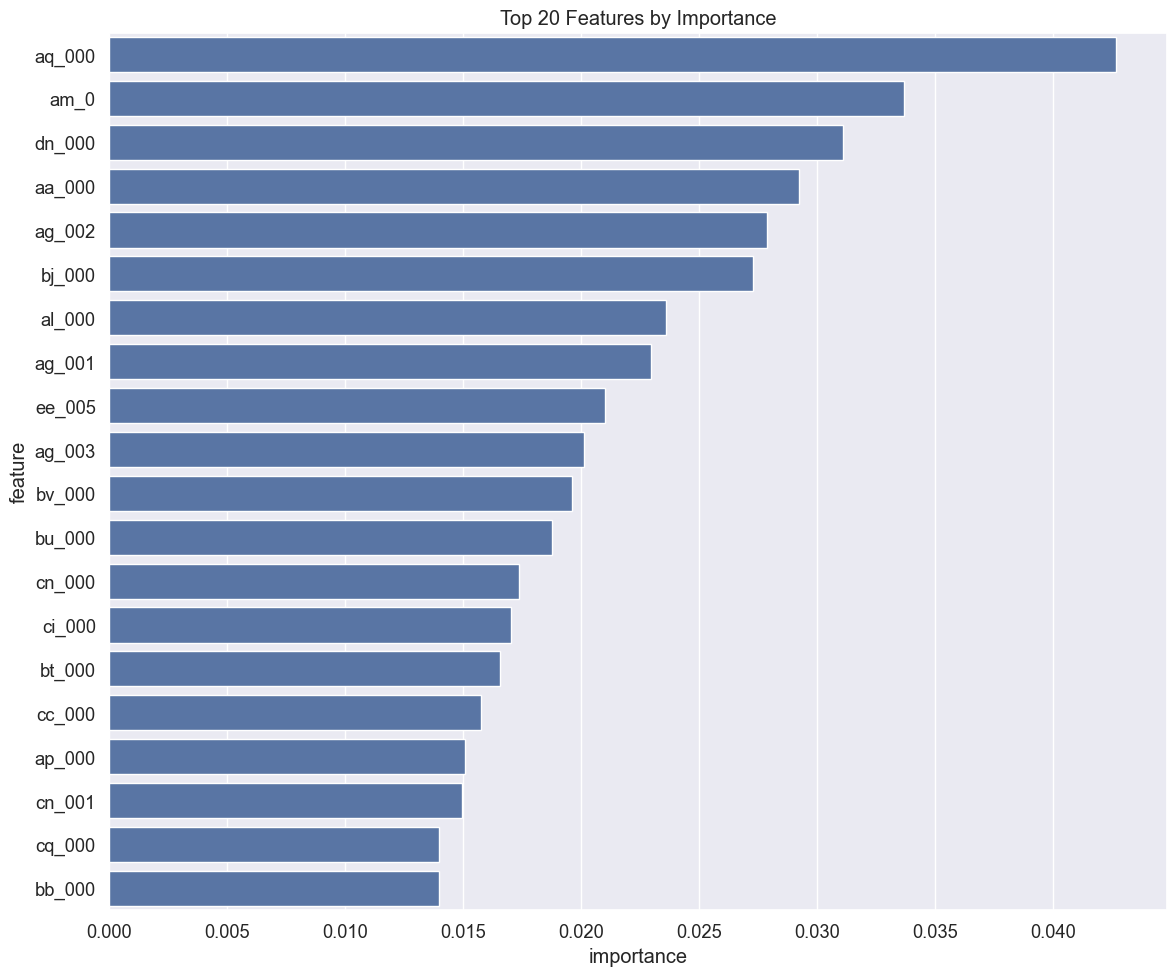

In [4]:
# For demonstration, we'll load the data directly
# In a real workflow, you would load the processed data from the previous notebook

# Define paths to dataset files
data_dir = '../aps_failure_at_scania_trucks'
train_file = os.path.join(data_dir, 'aps_failure_training_set.csv')
test_file = os.path.join(data_dir, 'aps_failure_test_set.csv')

# Load the training and test datasets
print(f"Loading training data from {train_file}")
train_data = pd.read_csv(train_file)

print(f"Loading test data from {test_file}")
test_data = pd.read_csv(test_file)

# Extract labels (class column)
y_train = train_data['class'].map({'neg': 0, 'pos': 1})
y_test = test_data['class'].map({'neg': 0, 'pos': 1})

# Extract features (all columns except 'class')
X_train = train_data.drop('class', axis=1)
X_test = test_data.drop('class', axis=1)

print(f"Loaded training data: {X_train.shape} features, {y_train.shape} labels")
print(f"Loaded test data: {X_test.shape} features, {y_test.shape} labels")

# Preprocess data
print("\nPreprocessing data...")

# Replace 'na' with NaN
X_train = X_train.replace('na', np.nan)
X_test = X_test.replace('na', np.nan)

# Convert to numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Handle missing values using median imputation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit imputer on training data and transform both train and test
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert back to DataFrame
X_train_processed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_processed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Apply standard scaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_processed),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_processed),
    columns=X_test.columns
)

print("Preprocessing complete.")

# Feature selection - for demonstration, we'll use a simple approach
# In practice, we would use the top features identified in the previous notebook
from sklearn.ensemble import RandomForestClassifier

# Calculate feature importance
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)
importances = model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})
top_features = feature_importance.sort_values('importance', ascending=False)
top_20_features = top_features.head(20)['feature'].tolist()

# Select top features
X_train_top = X_train_scaled[top_20_features]
X_test_top = X_test_scaled[top_20_features]

print(f"Selected {len(top_20_features)} top features for modeling.")
print(f"X_train_top shape: {X_train_top.shape}")
print(f"X_test_top shape: {X_test_top.shape}")

# Display top features
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=top_features.head(20))
plt.title('Top 20 Features by Importance')
plt.tight_layout()
plt.show()


## Step 4.2: Create Time Series Data for Forecasting


Using aq_000 as the target variable for time series forecasting


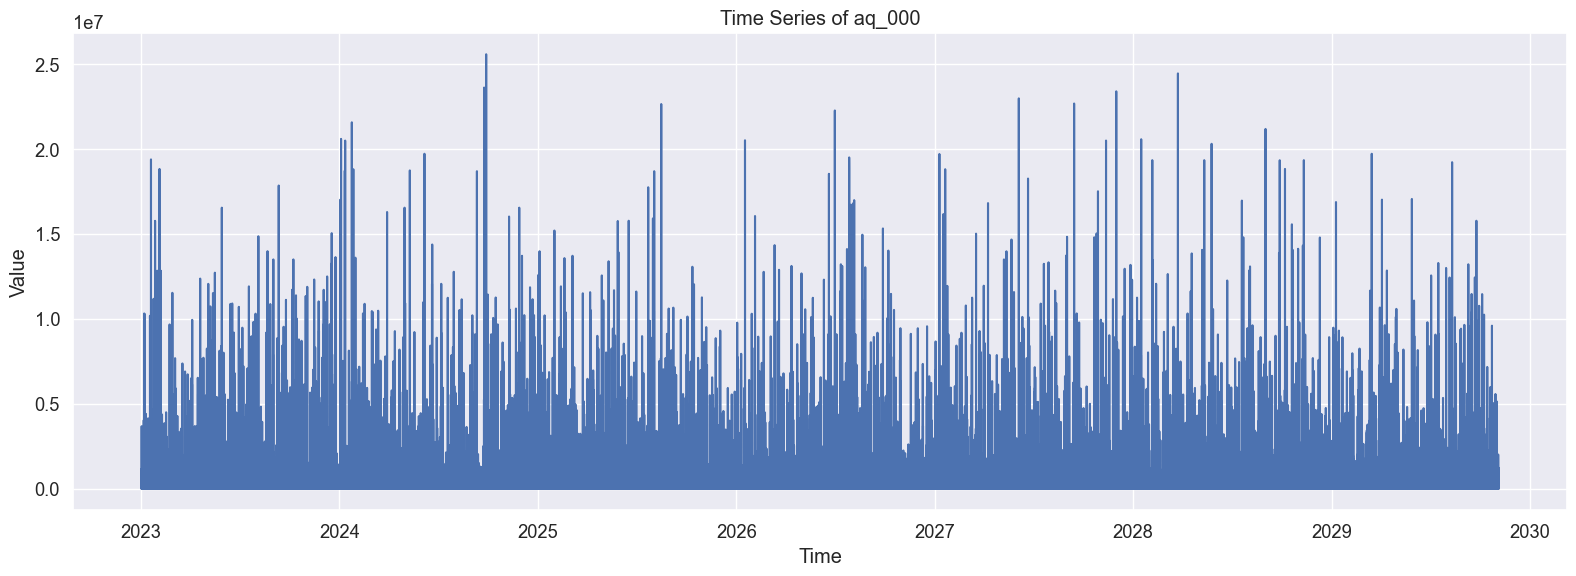

Using 5000 samples for time series modeling
Time series train set: 4000 samples
Time series validation set: 1000 samples


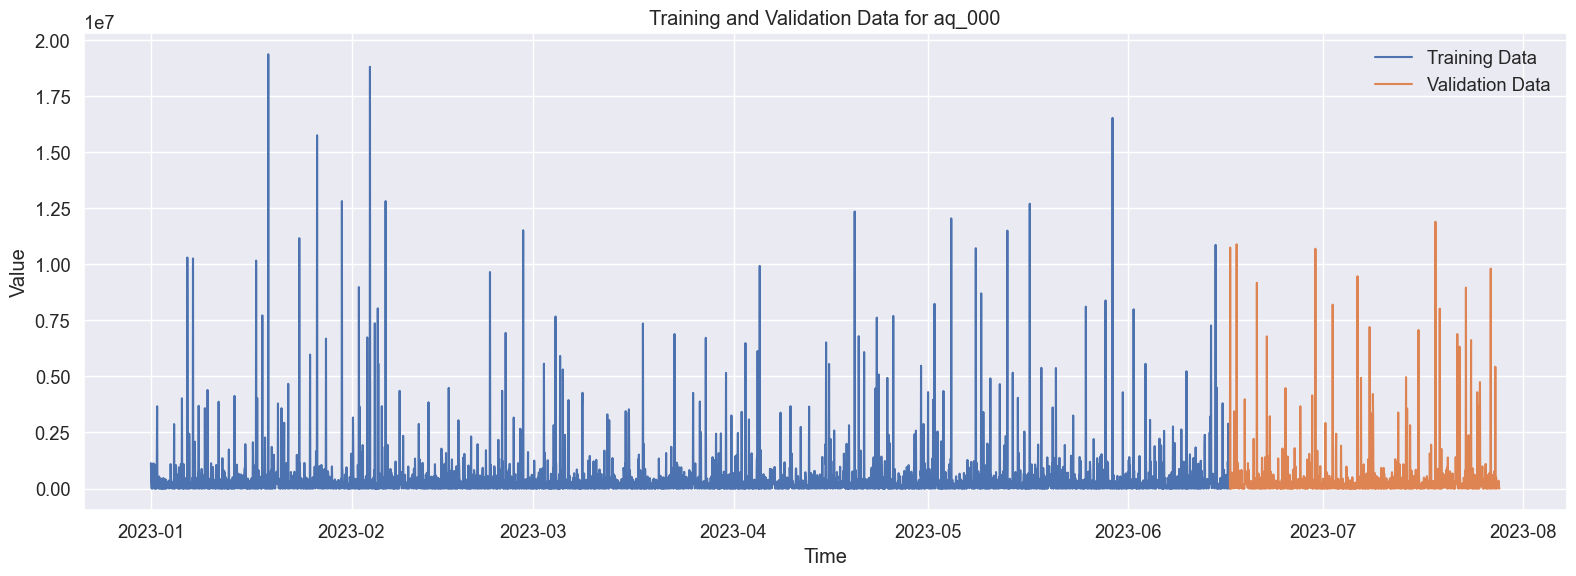

In [5]:
# For time series forecasting, we need to create a time series from our data
# Since our dataset doesn't have explicit time information, we'll create a synthetic time series
# using one of the top features as our target variable

# Select the top feature for time series forecasting
top_feature = top_features.iloc[0]['feature']
print(f"Using {top_feature} as the target variable for time series forecasting")

# Create a synthetic time series using the training data
# We'll assume each row represents a consecutive time point
time_index = pd.date_range(start='2023-01-01', periods=len(X_train_top), freq='H')
time_series = pd.Series(X_train_processed[top_feature].values, index=time_index)

# Plot the time series
plt.figure(figsize=(16, 6))
plt.plot(time_series)
plt.title(f'Time Series of {top_feature}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# For demonstration, we'll use a subset of the data to speed up computation
# In practice, you would use the full dataset
n_samples = 5000  # Number of samples to use
time_series_subset = time_series[:n_samples]

print(f"Using {len(time_series_subset)} samples for time series modeling")

# Split into training and validation sets for time series
train_size = int(len(time_series_subset) * 0.8)
time_series_train = time_series_subset[:train_size]
time_series_val = time_series_subset[train_size:]

print(f"Time series train set: {len(time_series_train)} samples")
print(f"Time series validation set: {len(time_series_val)} samples")

# Plot the training and validation sets
plt.figure(figsize=(16, 6))
plt.plot(time_series_train, label='Training Data')
plt.plot(time_series_val, label='Validation Data')
plt.title(f'Training and Validation Data for {top_feature}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 4.3: ARIMA Model for Time Series Forecasting


Testing stationarity of the time series:
ADF Statistic: -64.3071
p-value: 0.0000
Critical Value (1%): -3.4320
Critical Value (5%): -2.8623
Critical Value (10%): -2.5672
Result: Stationary (reject null hypothesis)

Finding optimal ARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=123901.142, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=123859.377, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=123867.289, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=123810.856, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=123788.632, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=123766.763, Time=0.11 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=123749.135, Time=0.12 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=2.33 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=1.97 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=123398.599, Time=0.25 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC

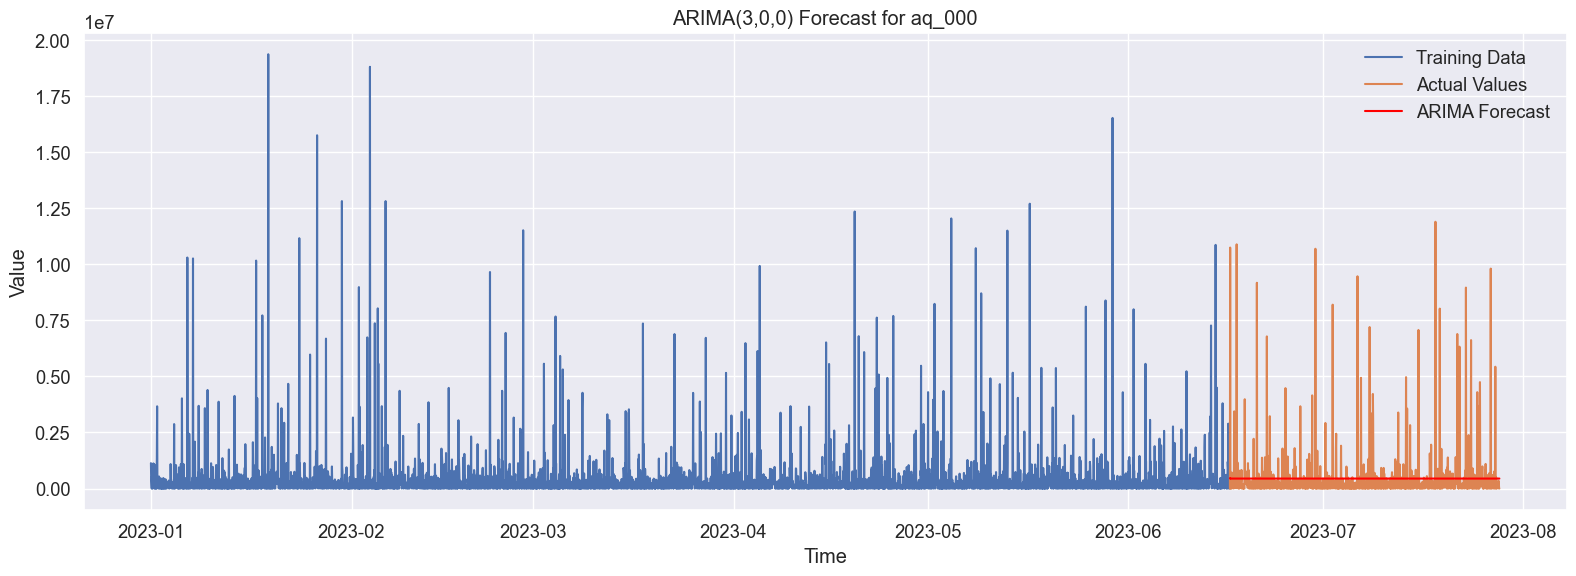

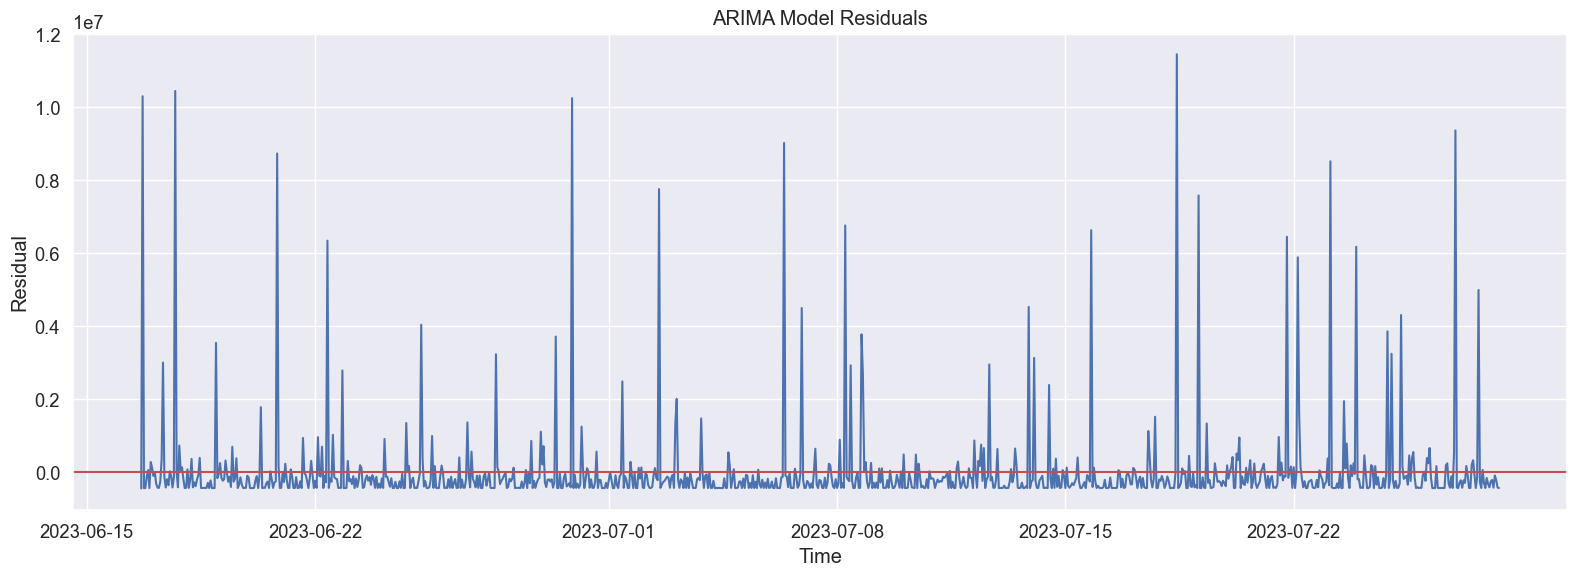

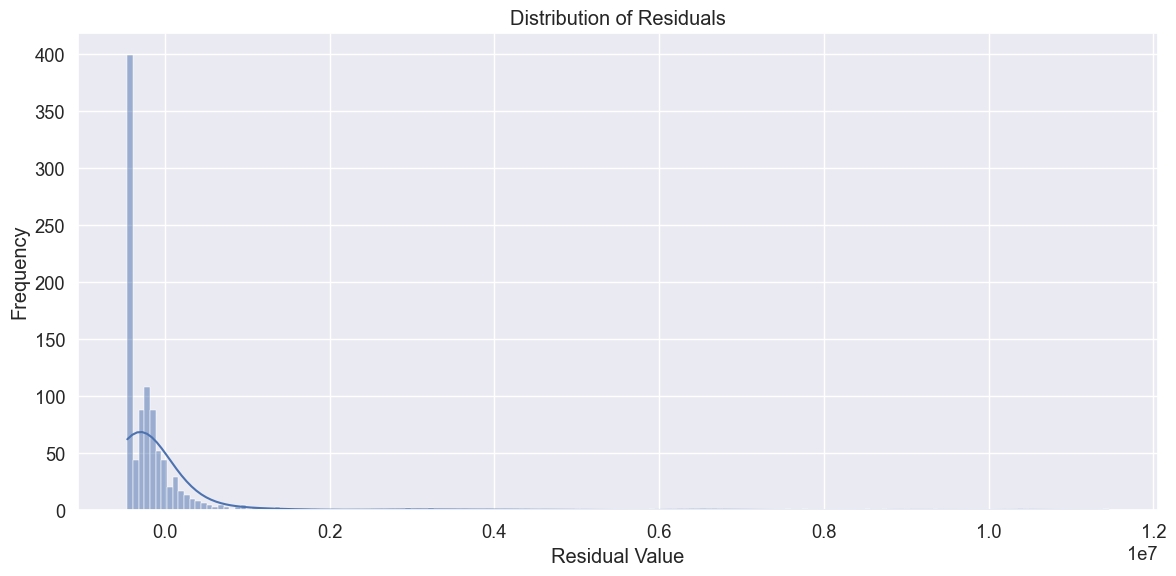

In [6]:
# First, let's check if the time series is stationary using ADF test
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    """Perform Augmented Dickey-Fuller test for stationarity"""
    result = adfuller(series.dropna())
    
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    
    # Print critical values
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value:.4f}')
    
    # Interpret results
    if result[1] <= 0.05:
        print("Result: Stationary (reject null hypothesis)")
    else:
        print("Result: Non-stationary (fail to reject null hypothesis)")

print("Testing stationarity of the time series:")
adf_test(time_series_train)

# Use auto_arima to automatically find the best ARIMA parameters
print("\nFinding optimal ARIMA parameters...")
auto_model = auto_arima(
    time_series_train,
    start_p=0, start_q=0,
    max_p=5, max_q=5, max_d=2,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(f"\nBest ARIMA model: {auto_model.order}")

# Fit the ARIMA model with the best parameters
p, d, q = auto_model.order
print(f"\nFitting ARIMA({p},{d},{q}) model...")
arima_model = ARIMA(time_series_train, order=(p, d, q))
arima_result = arima_model.fit()

# Print model summary
print("\nARIMA Model Summary:")
print(arima_result.summary())

# Make predictions on the validation set
print("\nMaking predictions on validation set...")
forecast_steps = len(time_series_val)
forecast = arima_result.forecast(steps=forecast_steps)

# Calculate error metrics
mse = mean_squared_error(time_series_val, forecast)
rmse = np.sqrt(mse)
r2 = r2_score(time_series_val, forecast)

print(f"\nARIMA Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot the results
plt.figure(figsize=(16, 6))
plt.plot(time_series_train.index, time_series_train, label='Training Data')
plt.plot(time_series_val.index, time_series_val, label='Actual Values')
plt.plot(time_series_val.index, forecast, label='ARIMA Forecast', color='red')
plt.title(f'ARIMA({p},{d},{q}) Forecast for {top_feature}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot residuals
residuals = time_series_val - forecast
plt.figure(figsize=(16, 6))
plt.plot(time_series_val.index, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('ARIMA Model Residuals')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot residual distribution
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 4.4: Prepare Data for LSTM Model


Creating sequences with length 24...
LSTM training data shape: (3976, 24, 1)
LSTM validation data shape: (976, 24, 1)


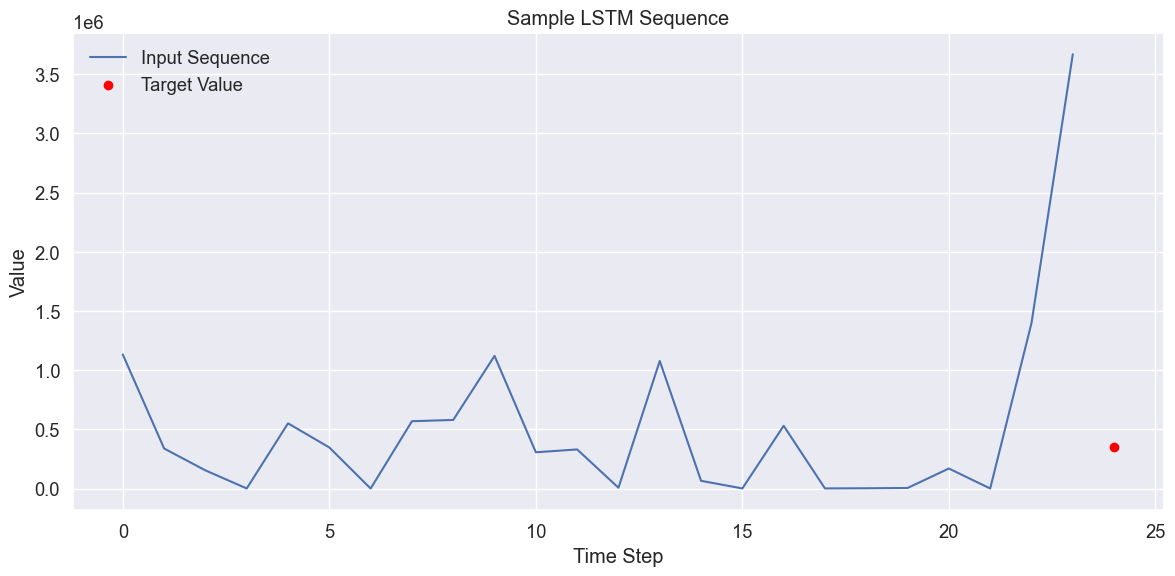

In [7]:
# Create sequences for LSTM model
def create_sequences(data, seq_length):
    """
    Create sequences for LSTM model
    
    Parameters:
    -----------
    data : array-like
        Input data
    seq_length : int
        Length of each sequence
        
    Returns:
    --------
    X : numpy.ndarray
        Input sequences
    y : numpy.ndarray
        Target values
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 24  # Use 24 hours (1 day) of data to predict the next hour

# Create sequences for training and validation
print(f"Creating sequences with length {seq_length}...")
X_train_lstm, y_train_lstm = create_sequences(time_series_train.values, seq_length)
X_val_lstm, y_val_lstm = create_sequences(time_series_val.values, seq_length)

# Reshape input to be [samples, time steps, features]
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_val_lstm = X_val_lstm.reshape((X_val_lstm.shape[0], X_val_lstm.shape[1], 1))

print(f"LSTM training data shape: {X_train_lstm.shape}")
print(f"LSTM validation data shape: {X_val_lstm.shape}")

# Display a sample sequence
plt.figure(figsize=(12, 6))
plt.plot(range(seq_length), X_train_lstm[0].flatten(), 'b-', label='Input Sequence')
plt.scatter(seq_length, y_train_lstm[0], color='red', label='Target Value')
plt.title('Sample LSTM Sequence')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 4.5: LSTM Model for Time Series Forecasting


Building and training LSTM model...

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 24, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________

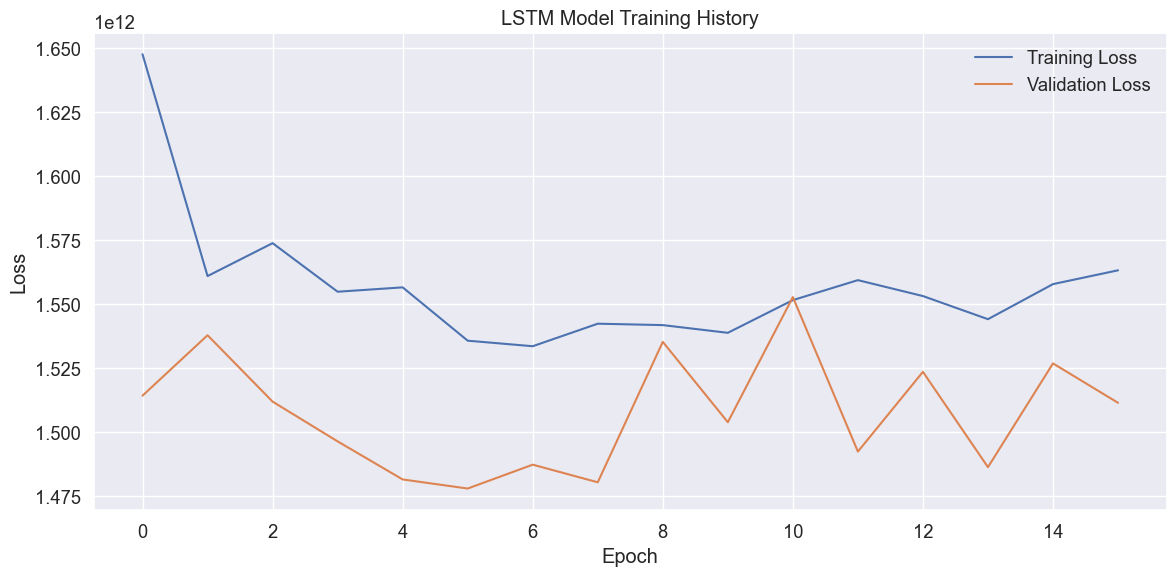


Evaluating LSTM model on validation data...
Validation Loss: 1477878874112.0000
31/31 [==============================] - 0s 3ms/step

LSTM Model Performance:
Mean Squared Error (MSE): 1477878914889.5508
Root Mean Squared Error (RMSE): 1215680.4329
R² Score: -0.0302


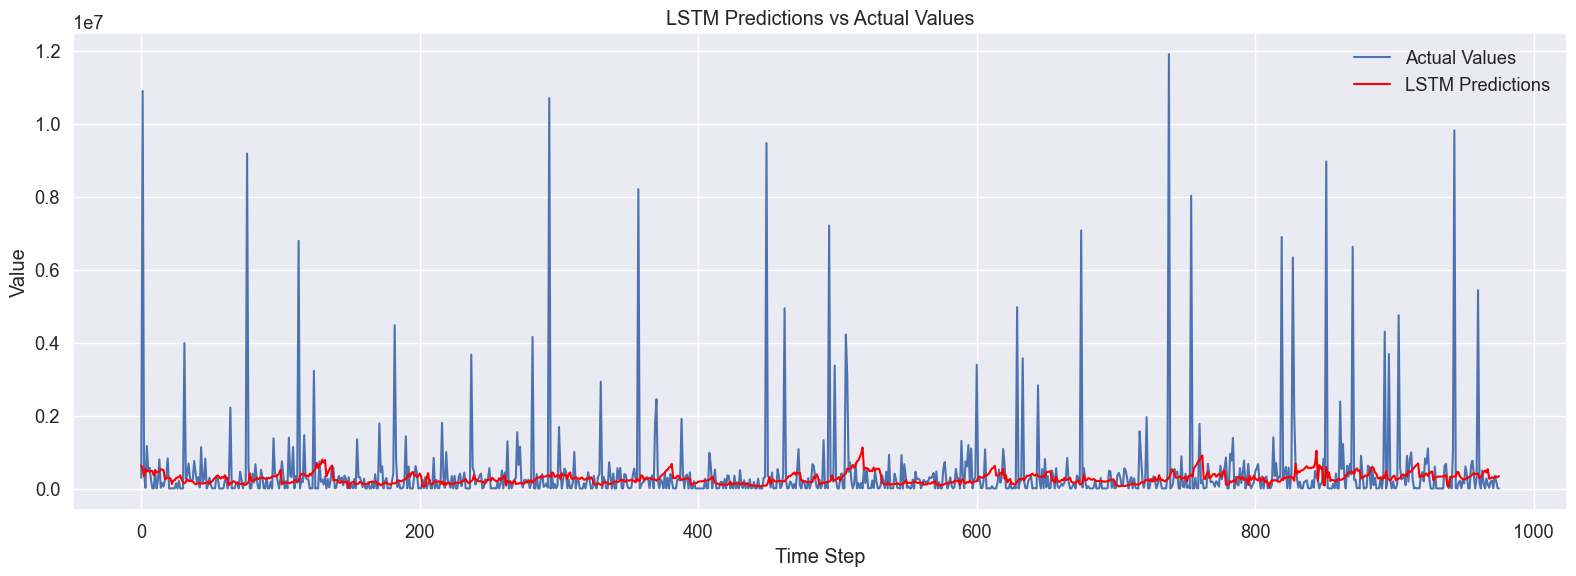

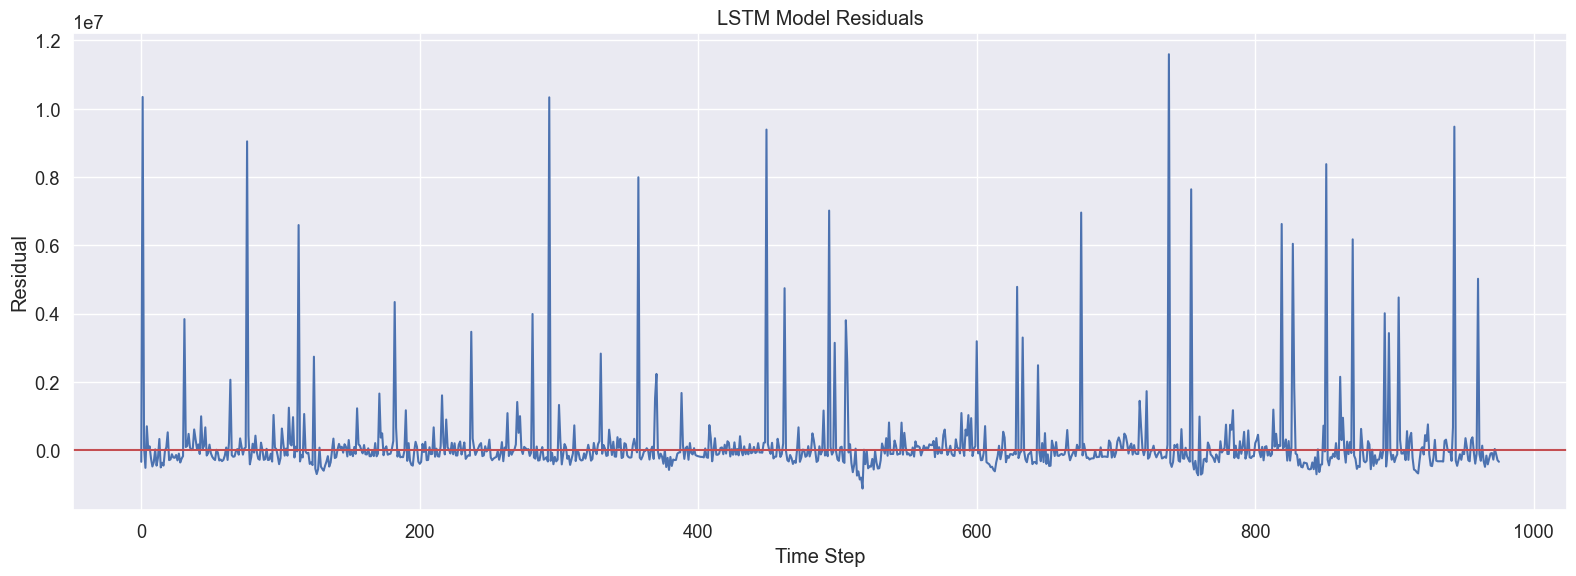

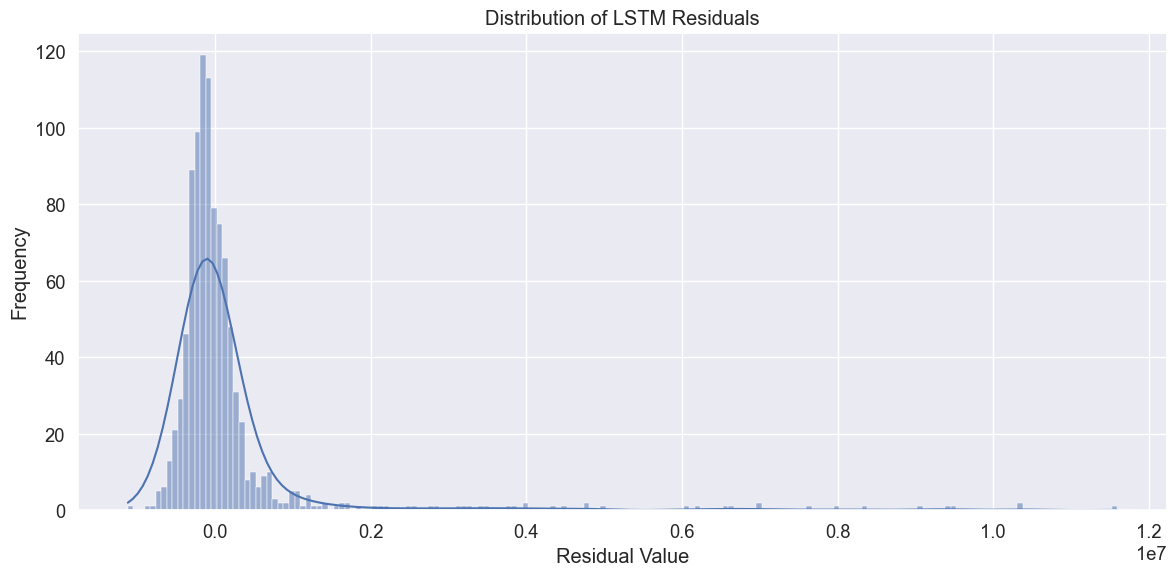

In [8]:
# Build LSTM model
def build_lstm_model(seq_length):
    """
    Build LSTM model for time series forecasting
    
    Parameters:
    -----------
    seq_length : int
        Length of input sequences
        
    Returns:
    --------
    model : tensorflow.keras.models.Sequential
        LSTM model
    """
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Create and train LSTM model
print("Building and training LSTM model...")
lstm_model = build_lstm_model(seq_length)
lstm_model.summary()

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_lstm, y_val_lstm),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate the model
print("\nEvaluating LSTM model on validation data...")
lstm_val_loss = lstm_model.evaluate(X_val_lstm, y_val_lstm, verbose=0)
print(f"Validation Loss: {lstm_val_loss:.4f}")

# Make predictions
lstm_predictions = lstm_model.predict(X_val_lstm)

# Calculate error metrics
lstm_mse = mean_squared_error(y_val_lstm, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(y_val_lstm, lstm_predictions)

print(f"\nLSTM Model Performance:")
print(f"Mean Squared Error (MSE): {lstm_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {lstm_rmse:.4f}")
print(f"R² Score: {lstm_r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(16, 6))
plt.plot(y_val_lstm, label='Actual Values')
plt.plot(lstm_predictions, label='LSTM Predictions', color='red')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot residuals
lstm_residuals = y_val_lstm - lstm_predictions.flatten()
plt.figure(figsize=(16, 6))
plt.plot(lstm_residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('LSTM Model Residuals')
plt.xlabel('Time Step')
plt.ylabel('Residual')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot residual distribution
plt.figure(figsize=(12, 6))
sns.histplot(lstm_residuals, kde=True)
plt.title('Distribution of LSTM Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 4.6: Classification Models (Random Forest and XGBoost)


Training Random Forest Classifier...

Random Forest Classifier Performance:
Accuracy: 0.9794
Precision: 0.5354
Recall: 0.9280
F1 Score: 0.6790


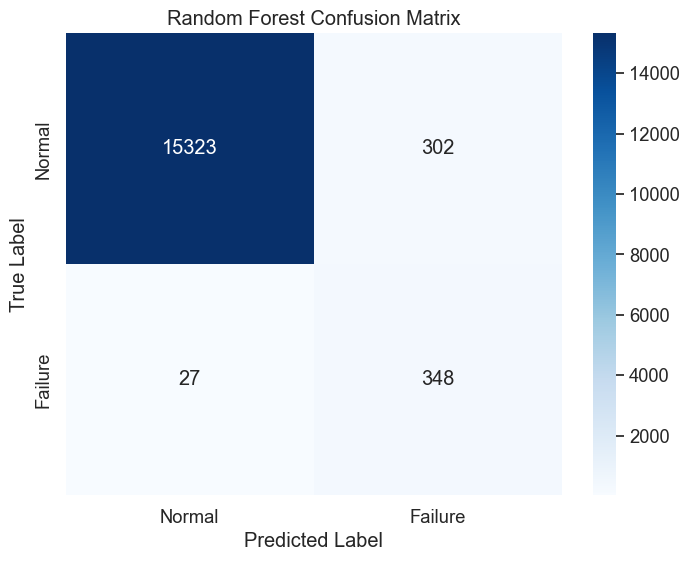


Random Forest Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     15625
     Failure       0.54      0.93      0.68       375

    accuracy                           0.98     16000
   macro avg       0.77      0.95      0.83     16000
weighted avg       0.99      0.98      0.98     16000



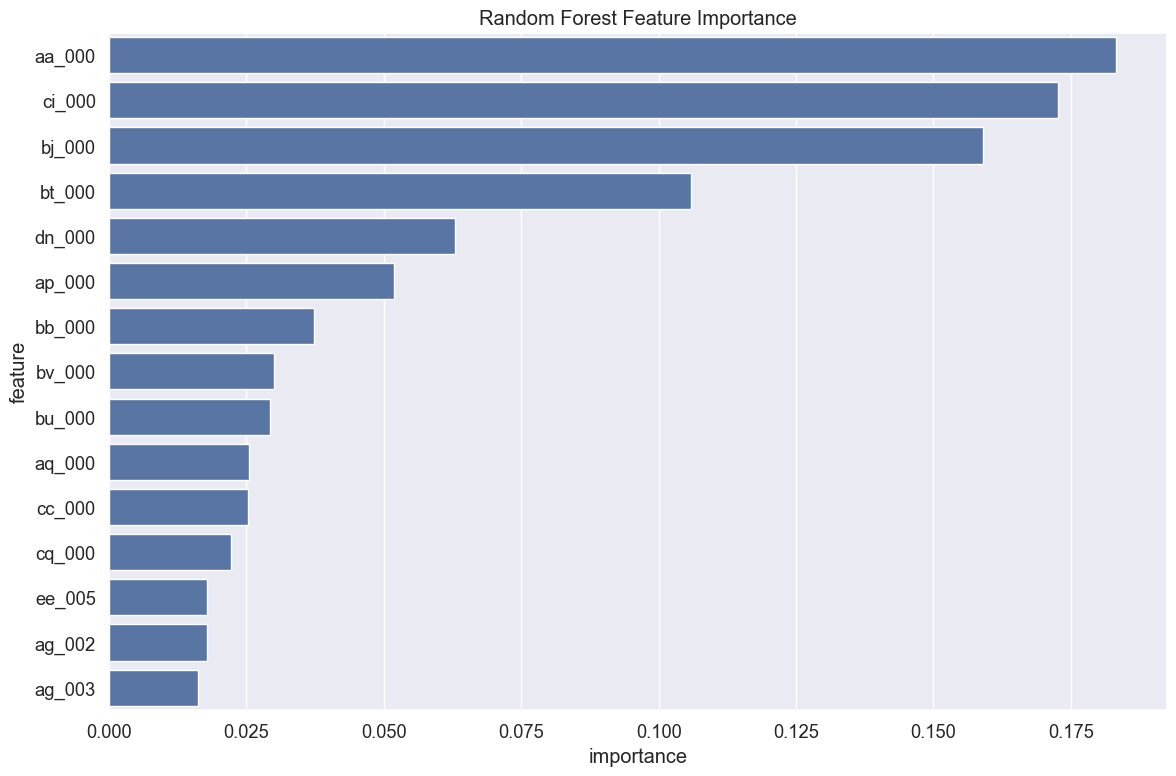


Training XGBoost Classifier...

XGBoost Classifier Performance:
Accuracy: 0.9764
Precision: 0.4979
Recall: 0.9547
F1 Score: 0.6545


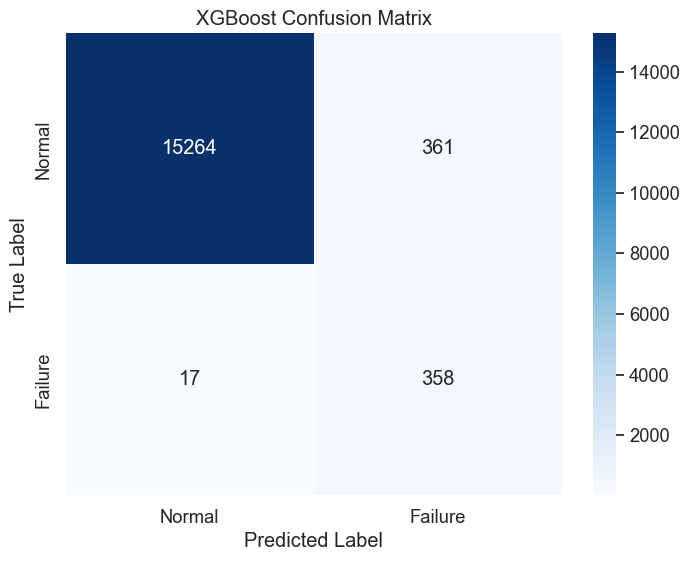


XGBoost Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     15625
     Failure       0.50      0.95      0.65       375

    accuracy                           0.98     16000
   macro avg       0.75      0.97      0.82     16000
weighted avg       0.99      0.98      0.98     16000



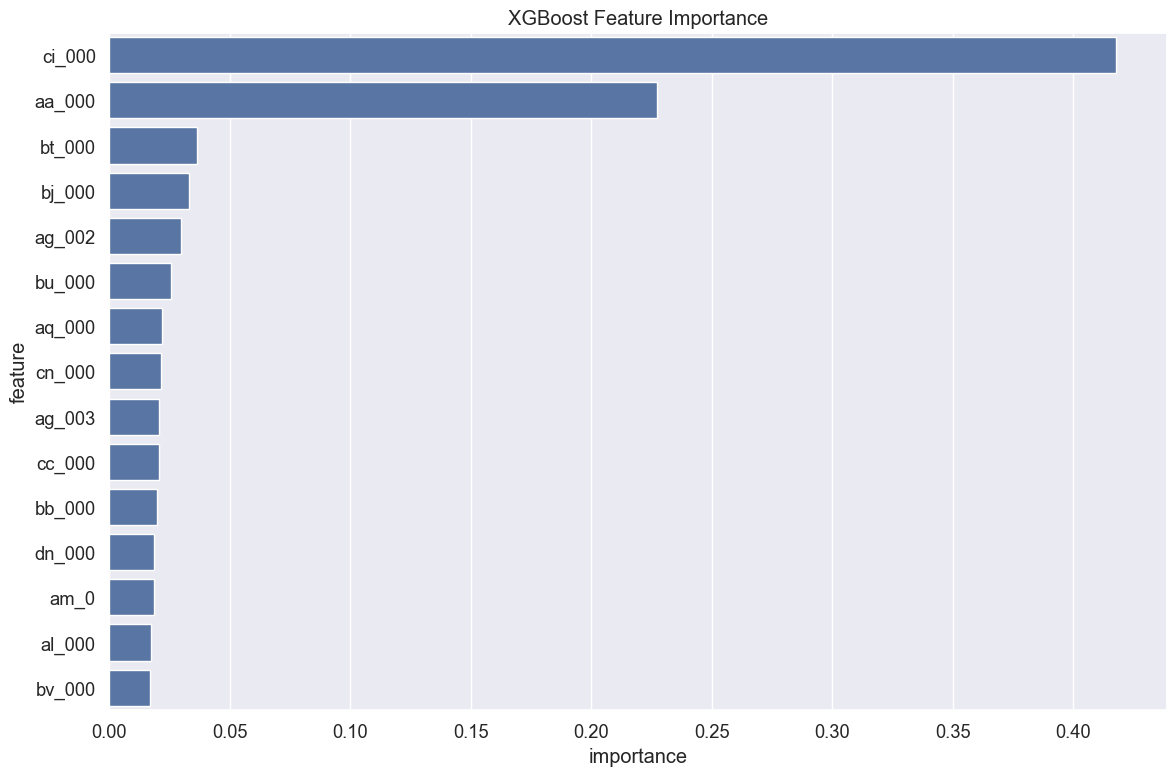

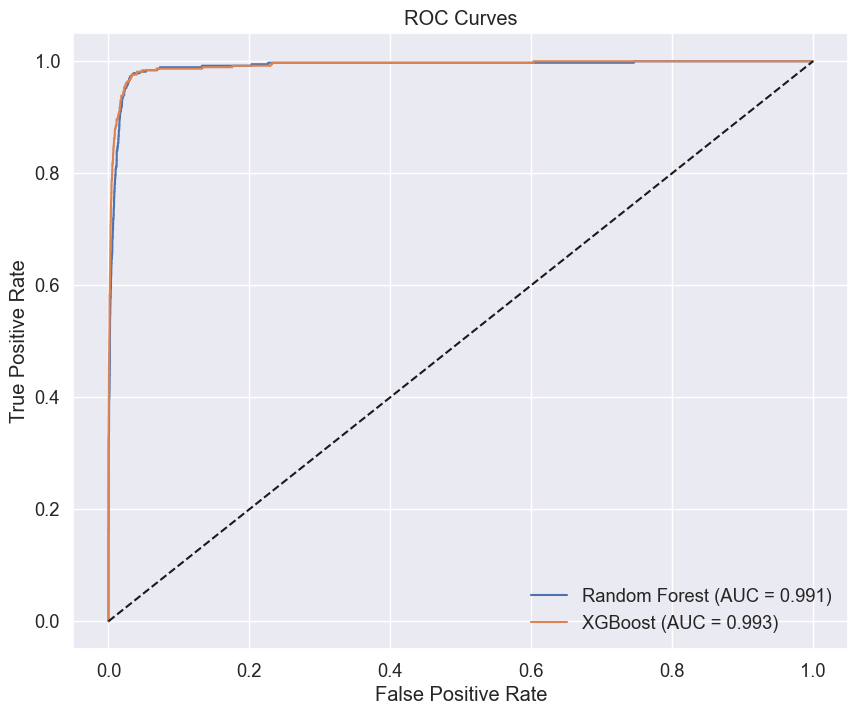

In [9]:
# Now let's implement classification models to predict failures
# We'll use the top features identified earlier

# Random Forest Classifier
print("Training Random Forest Classifier...")
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Handle class imbalance
)

# Train the model
rf_classifier.fit(X_train_top, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test_top)
y_pred_proba_rf = rf_classifier.predict_proba(X_test_top)[:, 1]

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(y_test, y_pred_rf, average='binary')

print(f"\nRandom Forest Classifier Performance:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")

# Display confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Failure'],
            yticklabels=['Normal', 'Failure'])
plt.title('Random Forest Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display classification report
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Normal', 'Failure']))

# Feature importance
rf_feature_importance = pd.DataFrame({
    'feature': X_train_top.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=rf_feature_importance.head(15))
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

# XGBoost Classifier
print("\nTraining XGBoost Classifier...")
xgb_classifier = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])  # Handle class imbalance
)

# Train the model
xgb_classifier.fit(X_train_top, y_train)

# Make predictions
y_pred_xgb = xgb_classifier.predict(X_test_top)
y_pred_proba_xgb = xgb_classifier.predict_proba(X_test_top)[:, 1]

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb, recall_xgb, f1_xgb, _ = precision_recall_fscore_support(y_test, y_pred_xgb, average='binary')

print(f"\nXGBoost Classifier Performance:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")

# Display confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Failure'],
            yticklabels=['Normal', 'Failure'])
plt.title('XGBoost Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display classification report
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Normal', 'Failure']))

# Feature importance
xgb_feature_importance = pd.DataFrame({
    'feature': X_train_top.columns,
    'importance': xgb_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=xgb_feature_importance.head(15))
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Plot ROC curves for both models
plt.figure(figsize=(10, 8))

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')

# XGBoost ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Step 4.7: Compare Models and Summarize Results


Regression Models Comparison:


,Model,MSE,RMSE,R²
0,ARIMA,1.517452e+12,1.231849e+06,0.000001
1,LSTM,1.477879e+12,1.215680e+06,-0.030240


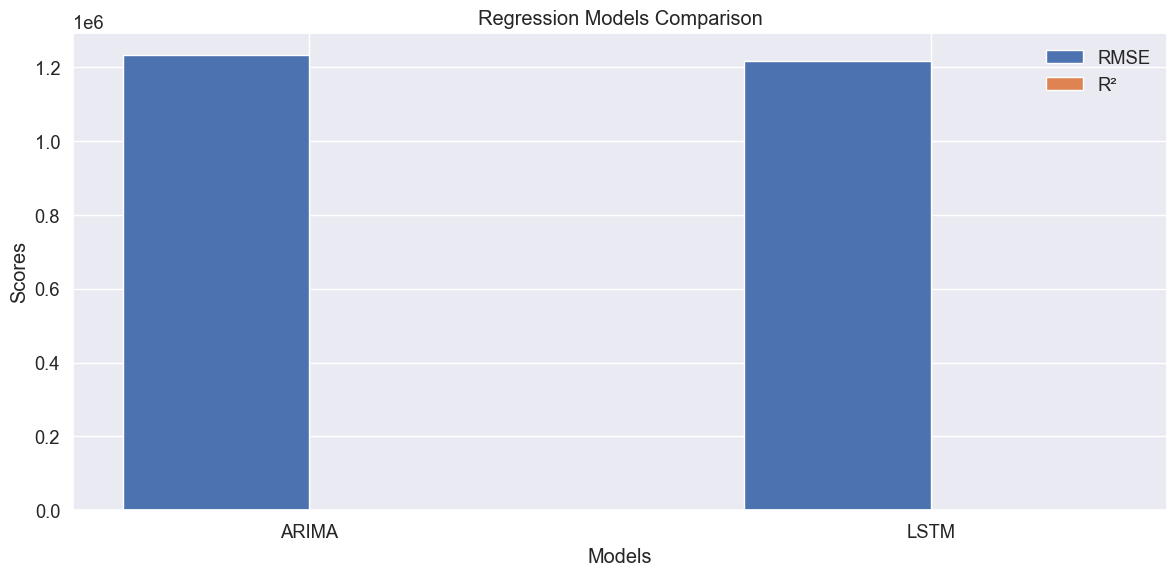


Classification Models Comparison:


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.979437,0.535385,0.928000,0.679024,0.990934
1,XGBoost,0.976375,0.497914,0.954667,0.654479,0.992509


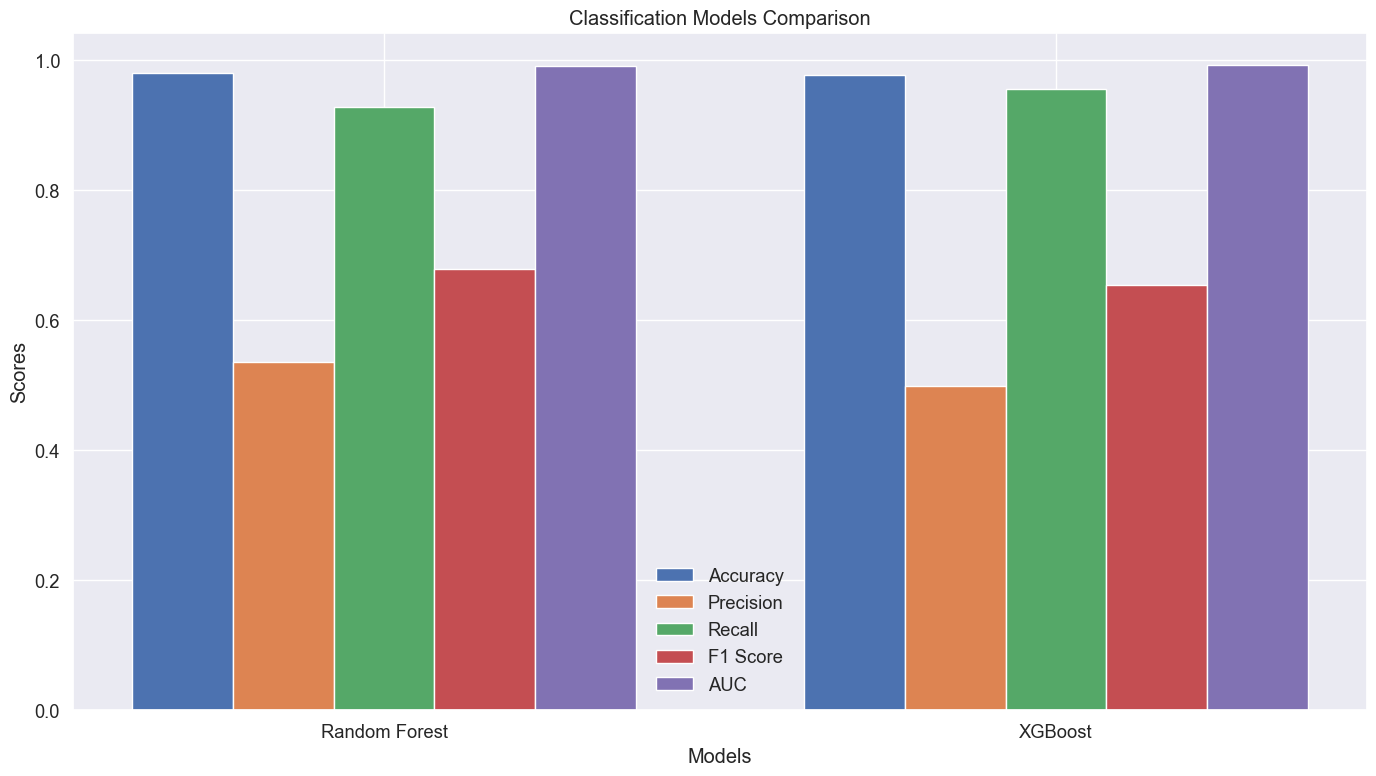


Summary of Findings:

1. Regression Models (Time Series Forecasting):
   - Best model: ARIMA with R² = 0.0000
   - ARIMA model: 3,0,0 configuration
   - LSTM model: 2 layers with 50 units each

2. Classification Models (Failure Prediction):
   - Best model: Random Forest with F1 Score = 0.6790
   - Random Forest: 0.9794 accuracy, 0.5354 precision, 0.9280 recall
   - XGBoost: 0.9764 accuracy, 0.4979 precision, 0.9547 recall

3. Key Features:
   - Top time series feature: aq_000
   - Top classification features: aa_000, ci_000, bj_000

4. Next Steps:
   - Perform cross-validation for more robust evaluation
   - Fine-tune hyperparameters for the best models
   - Explore ensemble methods for improved performance
   - Implement the models in a production environment


In [10]:
# Compare regression models (ARIMA and LSTM)
regression_models = ['ARIMA', 'LSTM']
mse_values = [mse, lstm_mse]
rmse_values = [rmse, lstm_rmse]
r2_values = [r2, lstm_r2]

regression_comparison = pd.DataFrame({
    'Model': regression_models,
    'MSE': mse_values,
    'RMSE': rmse_values,
    'R²': r2_values
})

print("Regression Models Comparison:")
display(regression_comparison)

# Plot regression model comparison
plt.figure(figsize=(12, 6))
bar_width = 0.3
index = np.arange(len(regression_models))

plt.bar(index, rmse_values, bar_width, label='RMSE')
plt.bar(index + bar_width, r2_values, bar_width, label='R²')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Regression Models Comparison')
plt.xticks(index + bar_width/2, regression_models)
plt.legend()
plt.tight_layout()
plt.show()

# Compare classification models (Random Forest and XGBoost)
classification_models = ['Random Forest', 'XGBoost']
accuracy_values = [accuracy_rf, accuracy_xgb]
precision_values = [precision_rf, precision_xgb]
recall_values = [recall_rf, recall_xgb]
f1_values = [f1_rf, f1_xgb]
auc_values = [roc_auc_rf, roc_auc_xgb]

classification_comparison = pd.DataFrame({
    'Model': classification_models,
    'Accuracy': accuracy_values,
    'Precision': precision_values,
    'Recall': recall_values,
    'F1 Score': f1_values,
    'AUC': auc_values
})

print("\nClassification Models Comparison:")
display(classification_comparison)

# Plot classification model comparison
plt.figure(figsize=(14, 8))
bar_width = 0.15
index = np.arange(len(classification_models))

plt.bar(index, accuracy_values, bar_width, label='Accuracy')
plt.bar(index + bar_width, precision_values, bar_width, label='Precision')
plt.bar(index + 2*bar_width, recall_values, bar_width, label='Recall')
plt.bar(index + 3*bar_width, f1_values, bar_width, label='F1 Score')
plt.bar(index + 4*bar_width, auc_values, bar_width, label='AUC')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Classification Models Comparison')
plt.xticks(index + 2*bar_width, classification_models)
plt.legend()
plt.tight_layout()
plt.show()

# Summary of findings
print("\nSummary of Findings:")
print("\n1. Regression Models (Time Series Forecasting):")
best_regression = regression_comparison.loc[regression_comparison['R²'].idxmax()]
print(f"   - Best model: {best_regression['Model']} with R² = {best_regression['R²']:.4f}")
print(f"   - ARIMA model: {p},{d},{q} configuration")
print(f"   - LSTM model: 2 layers with 50 units each")

print("\n2. Classification Models (Failure Prediction):")
best_classification = classification_comparison.loc[classification_comparison['F1 Score'].idxmax()]
print(f"   - Best model: {best_classification['Model']} with F1 Score = {best_classification['F1 Score']:.4f}")
print(f"   - Random Forest: {accuracy_rf:.4f} accuracy, {precision_rf:.4f} precision, {recall_rf:.4f} recall")
print(f"   - XGBoost: {accuracy_xgb:.4f} accuracy, {precision_xgb:.4f} precision, {recall_xgb:.4f} recall")

print("\n3. Key Features:")
print(f"   - Top time series feature: {top_feature}")
print(f"   - Top classification features: {', '.join(rf_feature_importance.head(3)['feature'].tolist())}")

print("\n4. Next Steps:")
print("   - Perform cross-validation for more robust evaluation")
print("   - Fine-tune hyperparameters for the best models")
print("   - Explore ensemble methods for improved performance")
print("   - Implement the models in a production environment")
